In [1]:
# import python libraries

# data analysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn utilities
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
# prediction
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
train_data = pd.read_csv('HPAR/train.csv')
test_data = pd.read_csv('HPAR/test.csv')
train_test_data = [train_data, test_data]
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Training data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [3]:
train_data.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


Summary:
* Several features have a lot of empty values.Probably we will drop them in the future.
* We have too many features (80) to use all of them in our predictions. We have to reduce feature's count next.
* Several features (e.g. LandContour) basically filled the same values. It could be transform to a binary feature.

# Analize features

In [4]:
id_test = test_data['Id'].tolist()

for data in train_test_data:
    data.drop(['Id'], axis=1, inplace=True)
print(train_data.shape, test_data.shape)

(1460, 80) (1459, 79)


In [5]:
train_data_num = train_data.select_dtypes(exclude=['object'])
test_data_num = test_data.select_dtypes(exclude=['object'])

In [6]:
# train_data_num.hist(figsize=(30, 30), bins=30)

In [7]:
selector = VarianceThreshold(threshold=0.05)

selector.fit(train_data_num.iloc[:, :-1])

sup = selector.get_support()

print('Number of retained features: ', sum(sup))
print('Number of low-variance features: ', sum(~sup))

low_var_fet = train_data_num.drop(['SalePrice'], axis=1).loc[:, ~sup].columns.values

print('Low-variance features: ', low_var_fet)

print('Before: ', train_data_num.shape, test_data_num.shape)
train_data_num.drop(low_var_fet, axis=1, inplace=True)
test_data_num.drop(low_var_fet, axis=1, inplace=True)
print('After: ', train_data_num.shape, test_data_num.shape)


Number of retained features:  35
Number of low-variance features:  1
Low-variance features:  ['KitchenAbvGr']
Before:  (1460, 37) (1459, 36)
After:  (1460, 36) (1459, 35)


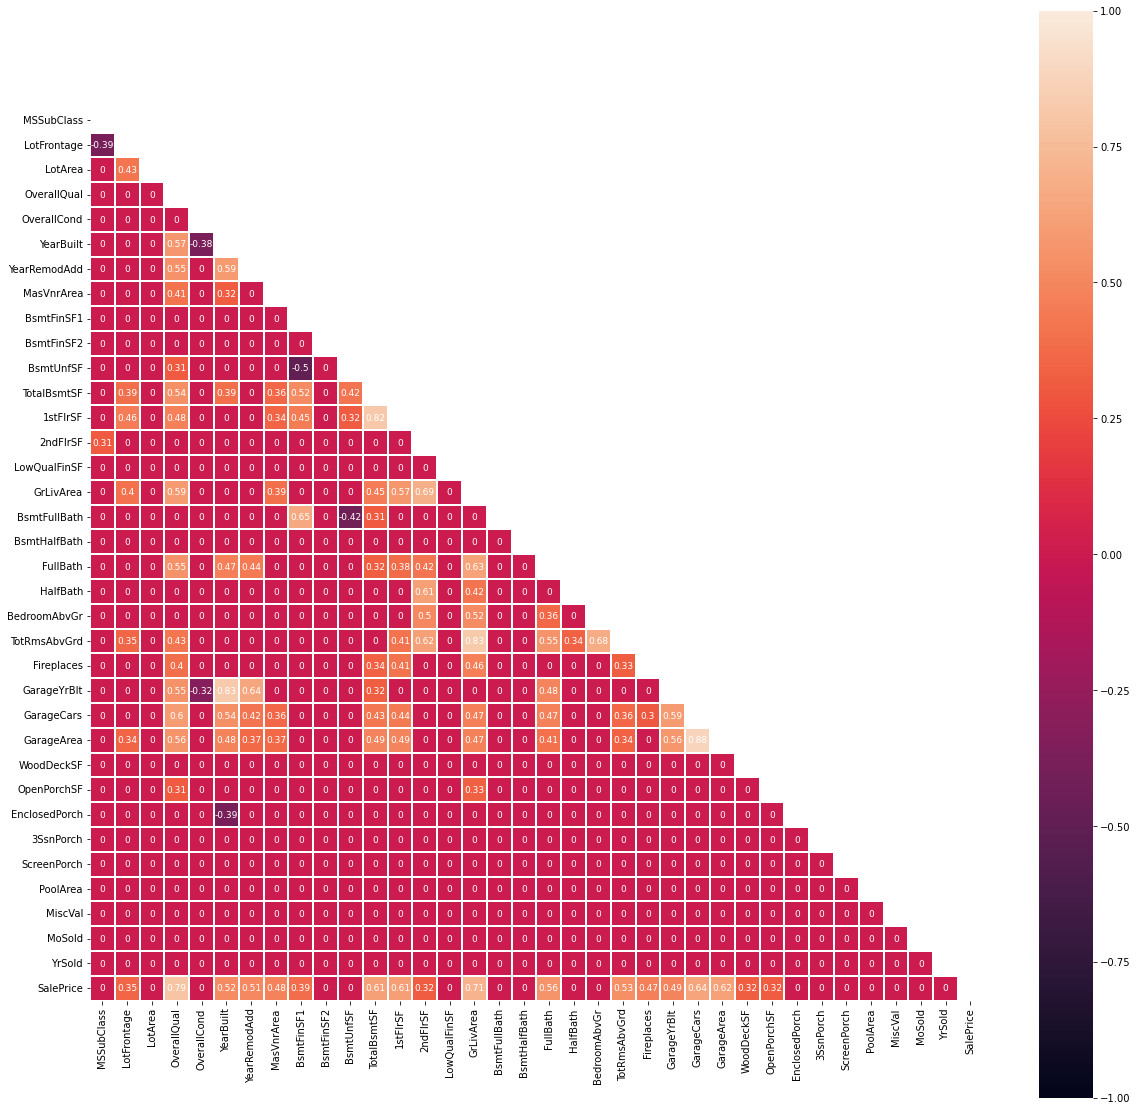

In [8]:
# pd.options.display.float_format = "{:, .2f}".format

corr_mat = train_data_num.corr()

# replace very weak correlation
corr_mat[(corr_mat < 0.3) & (corr_mat > -0.3)] = 0

# define triangular mask for better visibility
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr_mat, mask=mask, vmax=1.0, vmin=-1.0, square=True, 
            annot=True, annot_kws={'size': 9, 'color': 'white'},
            linewidths=0.01, cmap='rocket');

In [9]:
# corr_mat = train_data_num.corr()
# corr_mat[(corr_mat < 0.3) & (corr_mat > -0.3)] = 0
corr_features = corr_mat['SalePrice'].drop(['SalePrice'])
corr_features.sort_values(ascending=False)

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
MoSold           0.000000
EnclosedPorch    0.000000
3SsnPorch        0.000000
MiscVal          0.000000
ScreenPorch      0.000000
PoolArea         0.000000
MSSubClass       0.000000
BsmtHalfBath     0.000000
BedroomAbvGr     0.000000
HalfBath         0.000000
BsmtFullBath     0.000000
LowQualFinSF     0.000000
BsmtUnfSF        0.000000
BsmtFinSF2       0.000000
OverallCond      0.000000
LotArea          0.000000
YrSold           0.000000
Name: SalePrice, dtype: float64

Strongly correlated features:  ['OverallQual', 'GrLivArea']


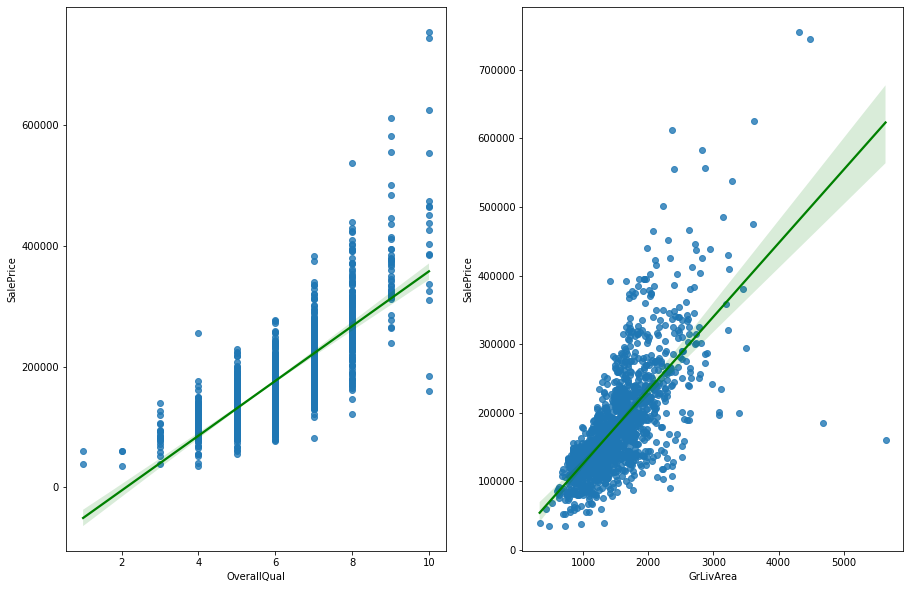

In [10]:
# strong correlation features (> 0.7)

strong_corr_fet_names = corr_features[abs(corr_features) >= 0.7].sort_values(ascending=False).index.tolist()
print('Strongly correlated features: ', strong_corr_fet_names)

strong_fet = train_data_num.loc[:, strong_corr_fet_names + ['SalePrice']]

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

for i, ax in enumerate(ax):
    if i < len(strong_corr_fet_names):
        sns.regplot(x=strong_corr_fet_names[i], y='SalePrice', data=strong_fet, ax=ax, line_kws={'color': 'green'})

Moderate correlation features:  ['GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']


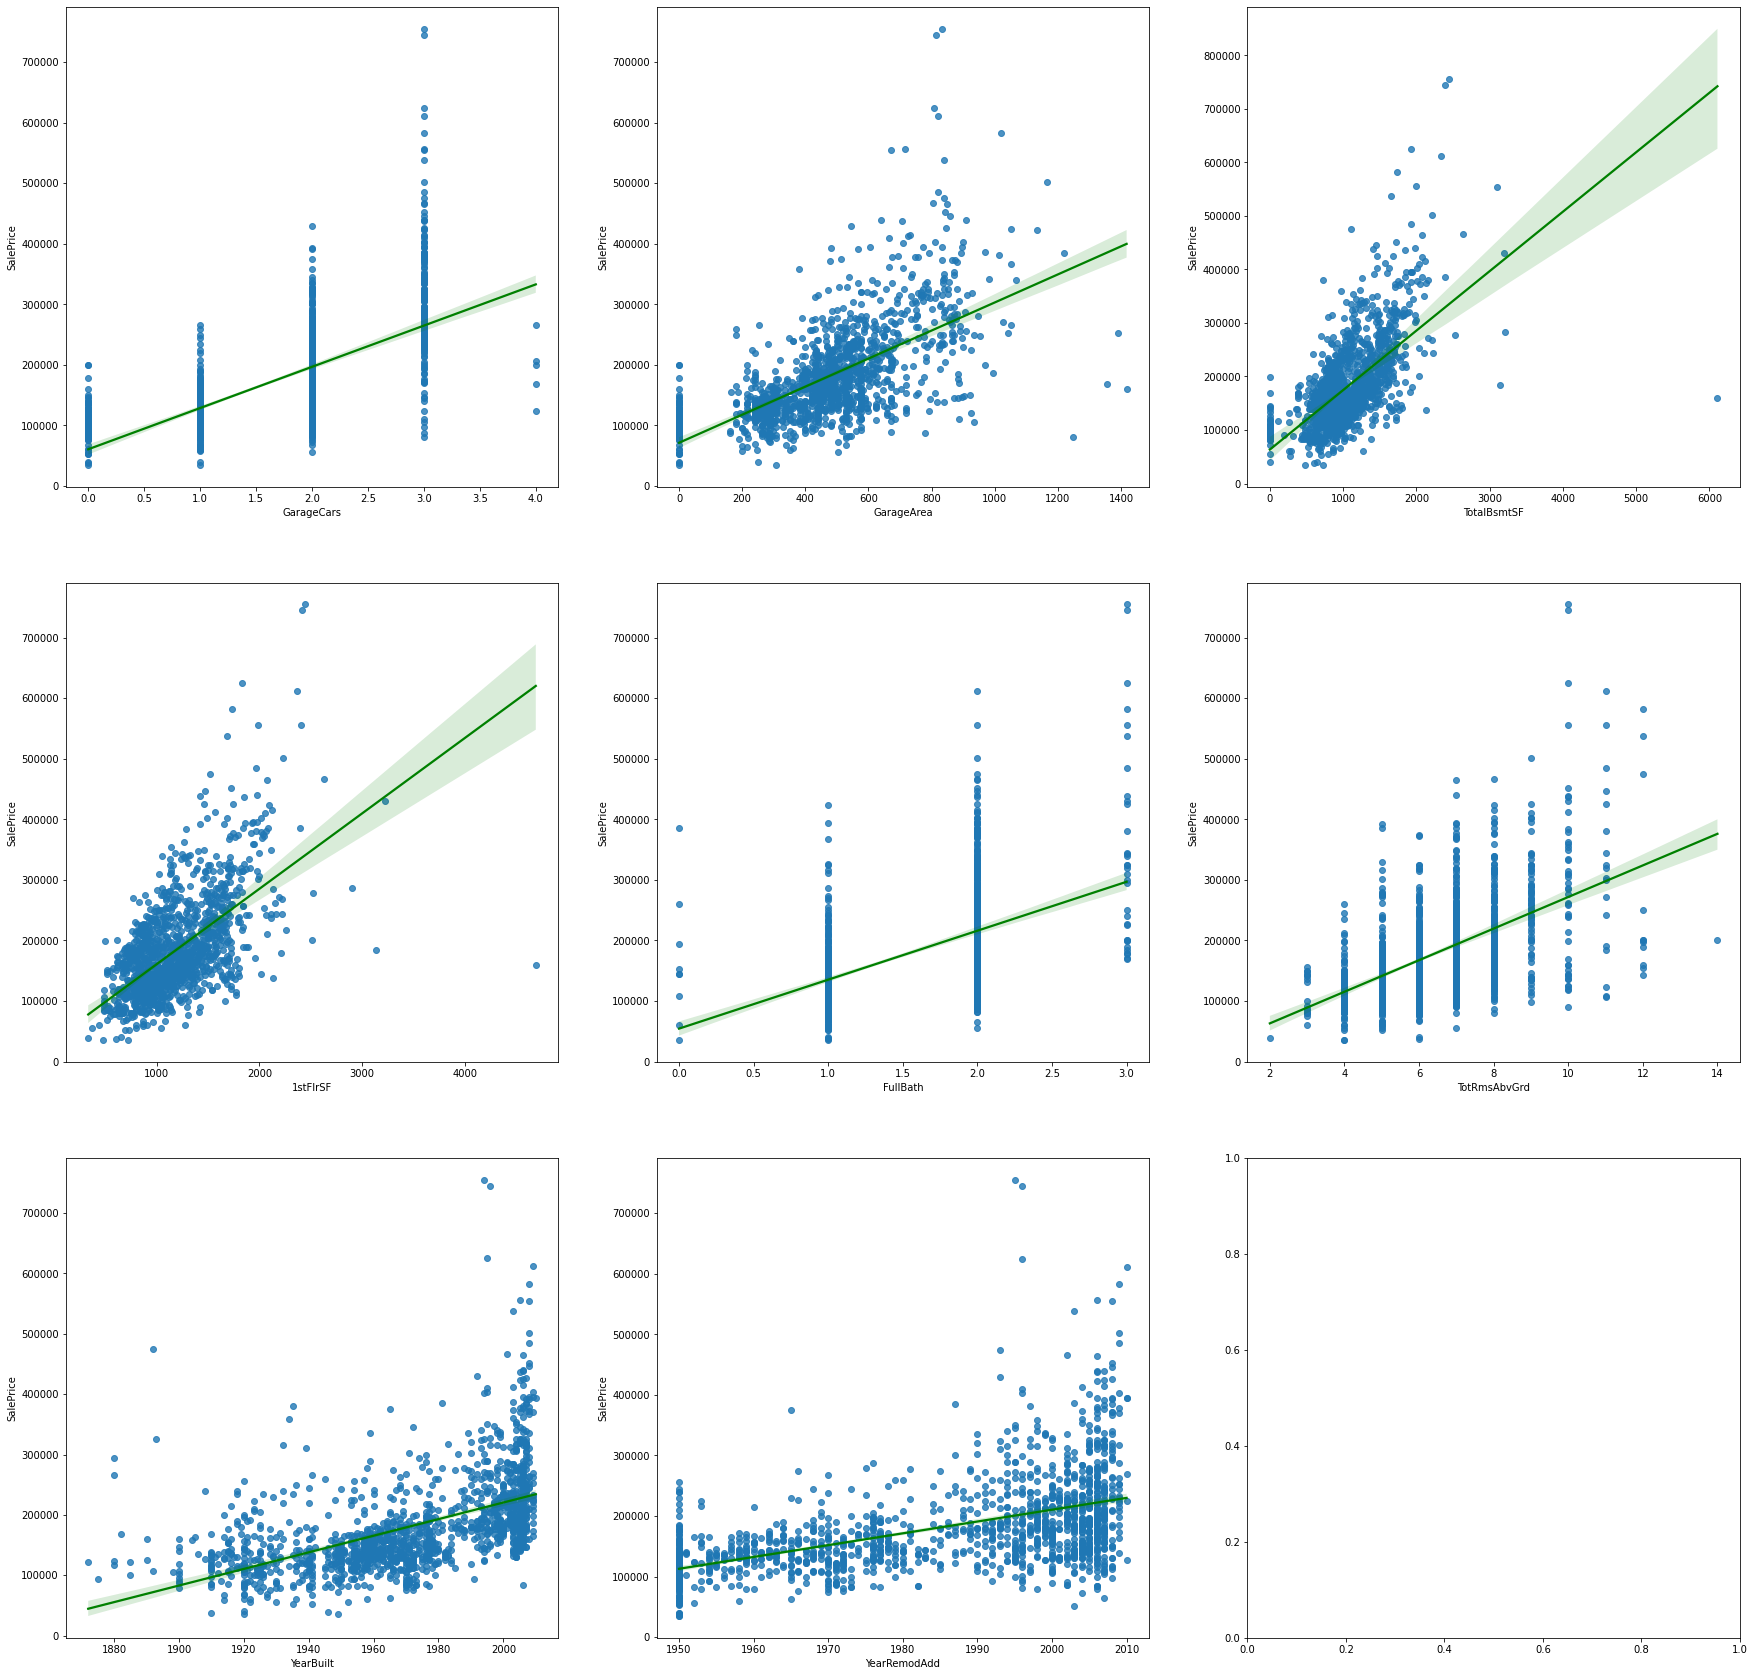

In [11]:
# strong correlation features (> 0.7)

moderate_fet_names = corr_features[(abs(corr_features) >= 0.5) & (abs(corr_features) < 0.7)].sort_values(ascending=False).index.tolist()
print('Moderate correlation features: ', moderate_fet_names)

moderate_fet = train_data_num.loc[:, moderate_fet_names + ['SalePrice']]

fig, ax = plt.subplots(3, 3, figsize=(30, 30))

for i, ax in enumerate(fig.axes):
    if i < len(moderate_fet_names):
        sns.regplot(x=moderate_fet_names[i], y='SalePrice', data=moderate_fet, ax=ax, line_kws={'color': 'green'})

Weakly correlated features:  ['GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF']


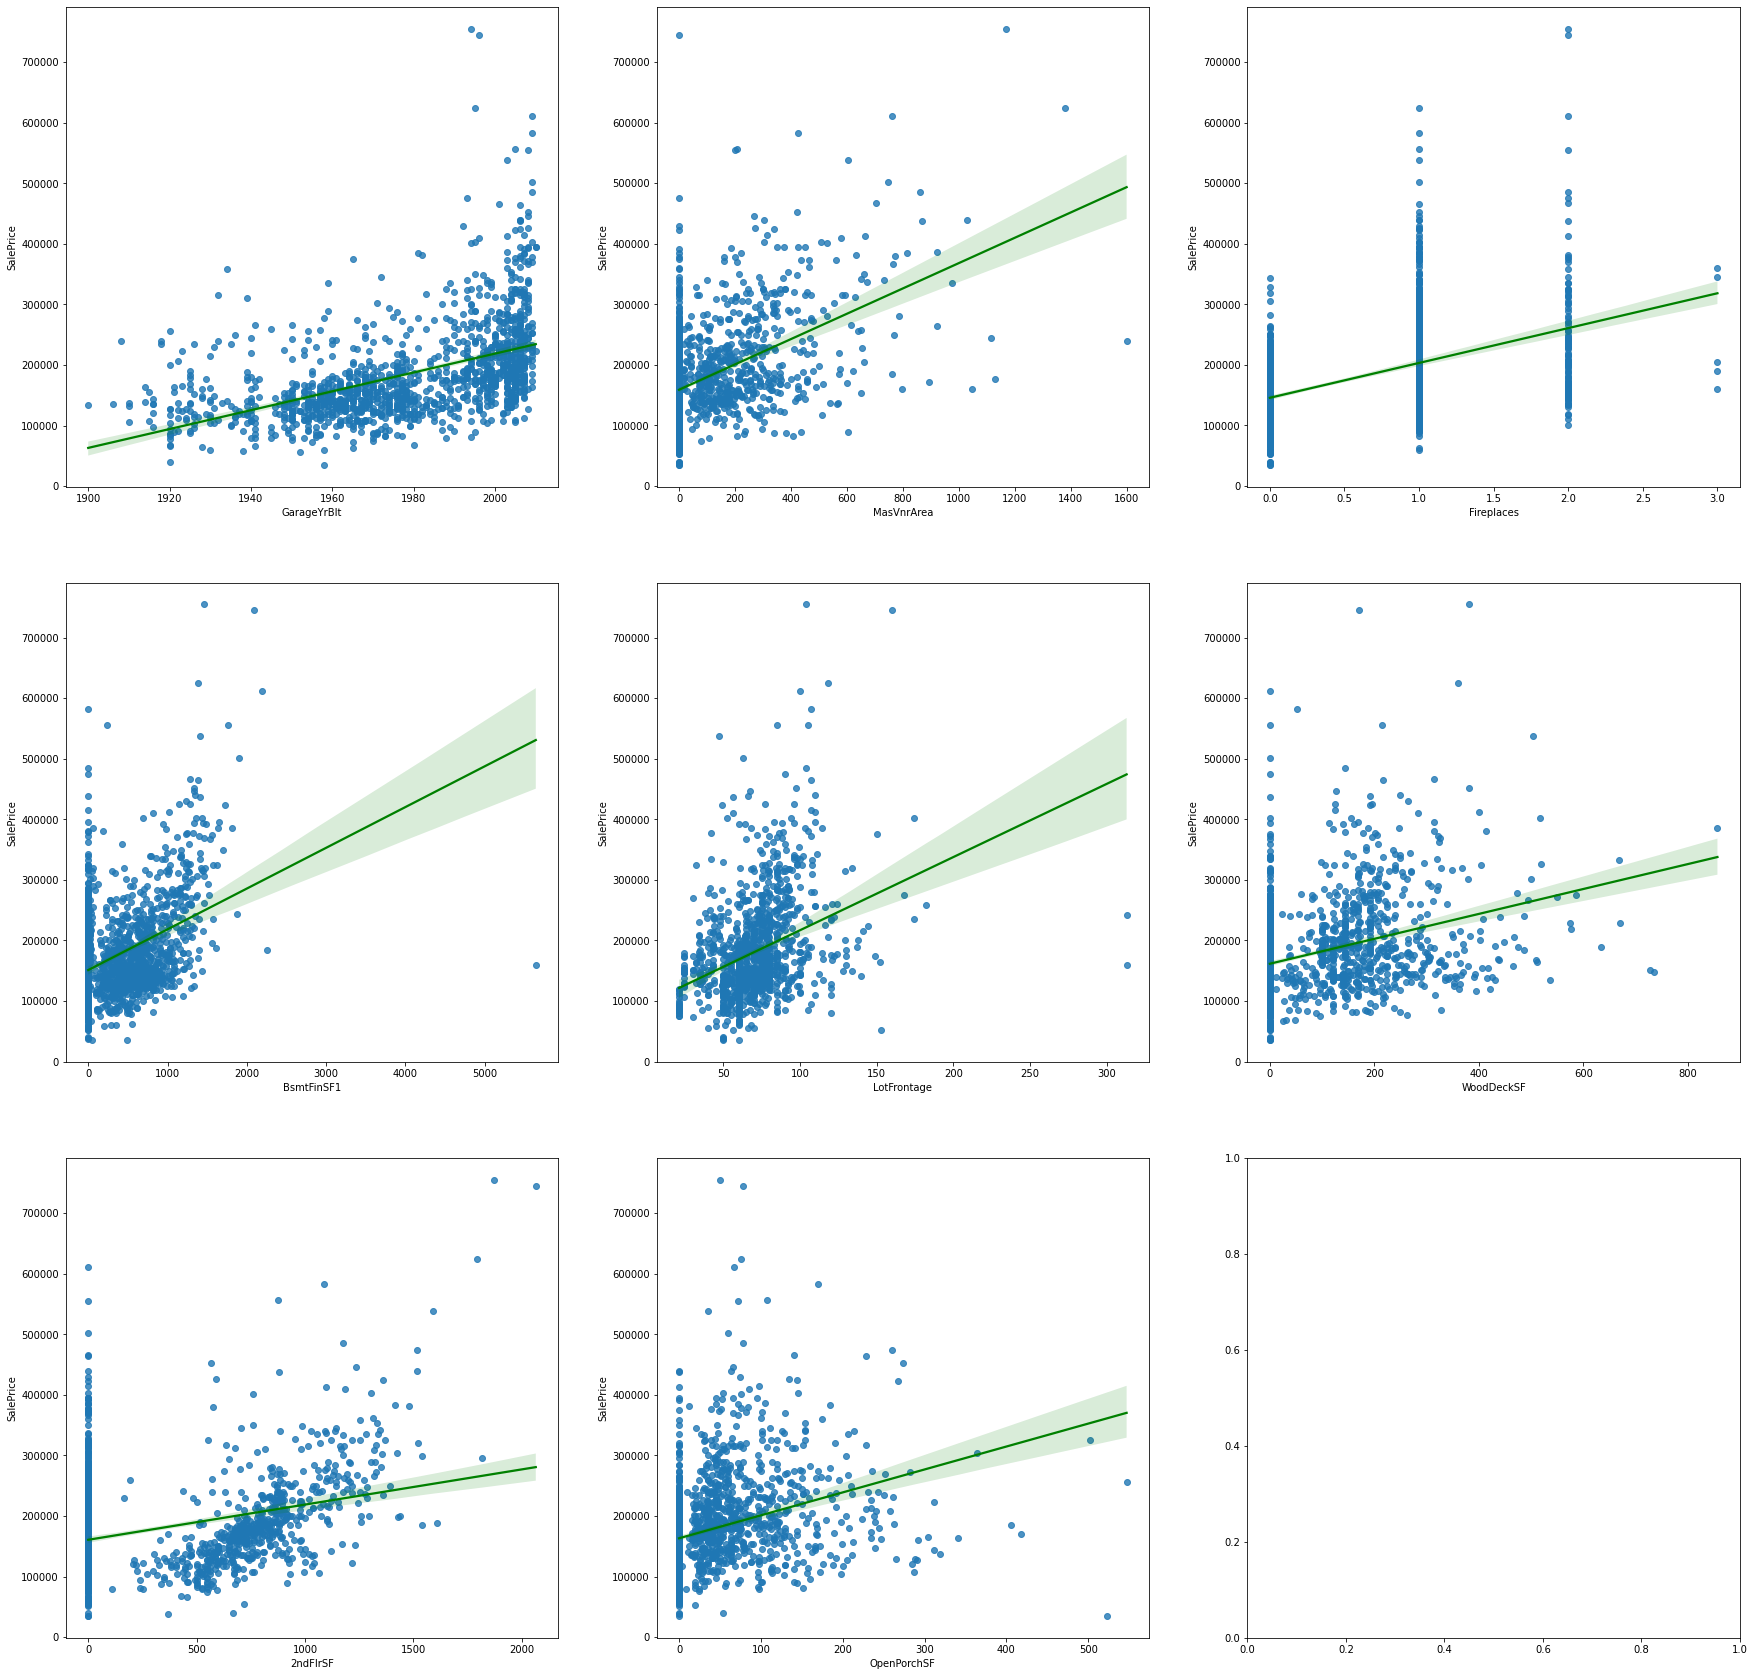

In [12]:
# weakly correlated features ( > 0.3 & < 0.5)

weak_fet_names = corr_features[(abs(corr_features) >= 0.3) & (abs(corr_features) < 0.5)].sort_values(ascending=False).index.tolist()
print('Weakly correlated features: ', weak_fet_names)

weak_fet = train_data_num.loc[:, weak_fet_names + ["SalePrice"]]

fig, ax = plt.subplots(3, 3, figsize=(30, 30))

for i, ax in enumerate(fig.axes):
    if i < len(weak_fet_names):
        sns.regplot(x=weak_fet_names[i], y='SalePrice', data=weak_fet, ax=ax, line_kws={'color': 'green'})

In [13]:
numerical_features = strong_corr_fet_names + moderate_fet_names + weak_fet_names + ['SalePrice']

train_data_num = train_data_num.loc[:, numerical_features]
# excepting SalePrice
test_data_num = test_data_num.loc[:, numerical_features[:-1]]
train_data_num.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,SalePrice
0,7,1710,2,548,856,856,2,8,2003,2003,2003.0,196.0,0,706,65.0,0,854,61,208500
1,6,1262,2,460,1262,1262,2,6,1976,1976,1976.0,0.0,1,978,80.0,298,0,0,181500
2,7,1786,2,608,920,920,2,6,2001,2002,2001.0,162.0,1,486,68.0,0,866,42,223500
3,7,1717,3,642,756,961,1,7,1915,1970,1998.0,0.0,1,216,60.0,0,756,35,140000
4,8,2198,3,836,1145,1145,2,9,2000,2000,2000.0,350.0,1,655,84.0,192,1053,84,250000


In [14]:
from itertools import combinations 

# find pairs of strongly correlated features
cols = train_data_num.columns.tolist()[:-1]
pairs = []

for pair in combinations(range(len(cols)), 2):
    if corr_mat.loc[cols[pair[0]], cols[pair[1]]] >= 0.7:
        pairs.append((cols[pair[0]], cols[pair[1]]))
        
        
pairs

[('GrLivArea', 'TotRmsAbvGrd'),
 ('GarageCars', 'GarageArea'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('YearBuilt', 'GarageYrBlt')]

In [15]:
# Now we can drop one feature from each pair

for _, col in pairs:
    train_data_num.drop(col, axis=1, inplace=True)
    test_data_num.drop(col, axis=1, inplace=True)

train_data_num.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,SalePrice
0,7,1710,2,856,2,2003,2003,196.0,0,706,65.0,0,854,61,208500
1,6,1262,2,1262,2,1976,1976,0.0,1,978,80.0,298,0,0,181500
2,7,1786,2,920,2,2001,2002,162.0,1,486,68.0,0,866,42,223500
3,7,1717,3,756,1,1915,1970,0.0,1,216,60.0,0,756,35,140000
4,8,2198,3,1145,2,2000,2000,350.0,1,655,84.0,192,1053,84,250000


In [16]:
train_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   GarageCars    1460 non-null   int64  
 3   TotalBsmtSF   1460 non-null   int64  
 4   FullBath      1460 non-null   int64  
 5   YearBuilt     1460 non-null   int64  
 6   YearRemodAdd  1460 non-null   int64  
 7   MasVnrArea    1452 non-null   float64
 8   Fireplaces    1460 non-null   int64  
 9   BsmtFinSF1    1460 non-null   int64  
 10  LotFrontage   1201 non-null   float64
 11  WoodDeckSF    1460 non-null   int64  
 12  2ndFlrSF      1460 non-null   int64  
 13  OpenPorchSF   1460 non-null   int64  
 14  SalePrice     1460 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 171.2 KB


In [17]:
test_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   GarageCars    1458 non-null   float64
 3   TotalBsmtSF   1458 non-null   float64
 4   FullBath      1459 non-null   int64  
 5   YearBuilt     1459 non-null   int64  
 6   YearRemodAdd  1459 non-null   int64  
 7   MasVnrArea    1444 non-null   float64
 8   Fireplaces    1459 non-null   int64  
 9   BsmtFinSF1    1458 non-null   float64
 10  LotFrontage   1232 non-null   float64
 11  WoodDeckSF    1459 non-null   int64  
 12  2ndFlrSF      1459 non-null   int64  
 13  OpenPorchSF   1459 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 159.7 KB


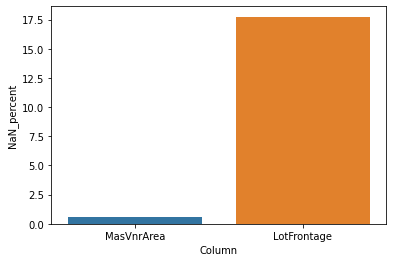

In [18]:
train_nan_cols = train_data_num.columns[train_data_num.isnull().any()].tolist()
train_nan = pd.DataFrame({ 'Column': train_nan_cols,
                         'NaN_percent': [ train_data_num[col].isnull().sum() * 100 / len(train_data_num) 
                                         for col in train_nan_cols] })
sns.barplot(data=train_nan, x='Column', y='NaN_percent');

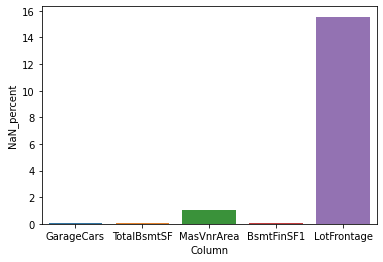

In [19]:
test_nan_cols = test_data_num.columns[test_data_num.isnull().any()].tolist()
test_nan = pd.DataFrame({ 'Column': test_nan_cols,
                         'NaN_percent': [ test_data_num[col].isnull().sum() * 100 / len(test_data_num) 
                                         for col in test_nan_cols] })
sns.barplot(data=test_nan, x='Column', y='NaN_percent');

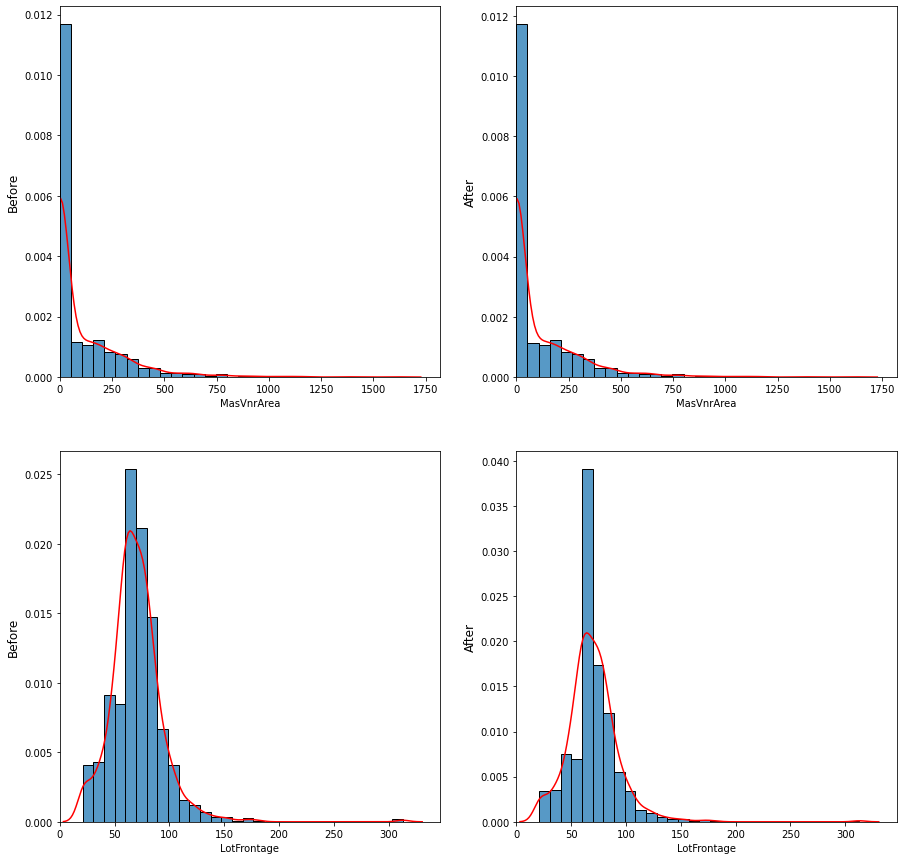

In [20]:
imp = SimpleImputer(strategy='median')
imp_train_data = pd.DataFrame(imp.fit_transform(train_data_num))
imp_train_data.columns = train_data_num.columns

fig, ax = plt.subplots(2,2, figsize=(15, 15))

for i, col in enumerate(train_nan_cols):
    
    # before filling NaN
    bfr = sns.histplot(data=train_data_num, x=col, ax=ax[i, 0], stat='density', bins=30)
    sns.kdeplot(data=train_data_num, x=col, ax=ax[i, 0], color='red')
    bfr.set_xlim(left=0)
    bfr.set_ylabel('Before', fontsize=12)
    
    # after filling NaN
    aftr = sns.histplot(data=imp_train_data, x=col, ax=ax[i, 1], stat='density', bins=30)
    sns.kdeplot(data=train_data_num, x=col, ax=ax[i, 1], color='red')
    aftr.set_xlim(left=0)
    aftr.set_ylabel('After', fontsize=12)

In [21]:
# drop LotFrontage
imp_train_data.drop(['LotFrontage'], axis=1, inplace=True)
test_data_num.drop(['LotFrontage'], axis=1, inplace=True)

# fill NaN in test data
imp = SimpleImputer(strategy='median')
imp_test_data = pd.DataFrame(imp.fit_transform(test_data_num))
imp_test_data.columns = test_data_num.columns

train_data_num = imp_train_data
test_data_num = imp_test_data

In [22]:
train_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   float64
 1   GrLivArea     1460 non-null   float64
 2   GarageCars    1460 non-null   float64
 3   TotalBsmtSF   1460 non-null   float64
 4   FullBath      1460 non-null   float64
 5   YearBuilt     1460 non-null   float64
 6   YearRemodAdd  1460 non-null   float64
 7   MasVnrArea    1460 non-null   float64
 8   Fireplaces    1460 non-null   float64
 9   BsmtFinSF1    1460 non-null   float64
 10  WoodDeckSF    1460 non-null   float64
 11  2ndFlrSF      1460 non-null   float64
 12  OpenPorchSF   1460 non-null   float64
 13  SalePrice     1460 non-null   float64
dtypes: float64(14)
memory usage: 159.8 KB


In [23]:
test_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   float64
 1   GrLivArea     1459 non-null   float64
 2   GarageCars    1459 non-null   float64
 3   TotalBsmtSF   1459 non-null   float64
 4   FullBath      1459 non-null   float64
 5   YearBuilt     1459 non-null   float64
 6   YearRemodAdd  1459 non-null   float64
 7   MasVnrArea    1459 non-null   float64
 8   Fireplaces    1459 non-null   float64
 9   BsmtFinSF1    1459 non-null   float64
 10  WoodDeckSF    1459 non-null   float64
 11  2ndFlrSF      1459 non-null   float64
 12  OpenPorchSF   1459 non-null   float64
dtypes: float64(13)
memory usage: 148.3 KB


# Now we need to get out of outliers.

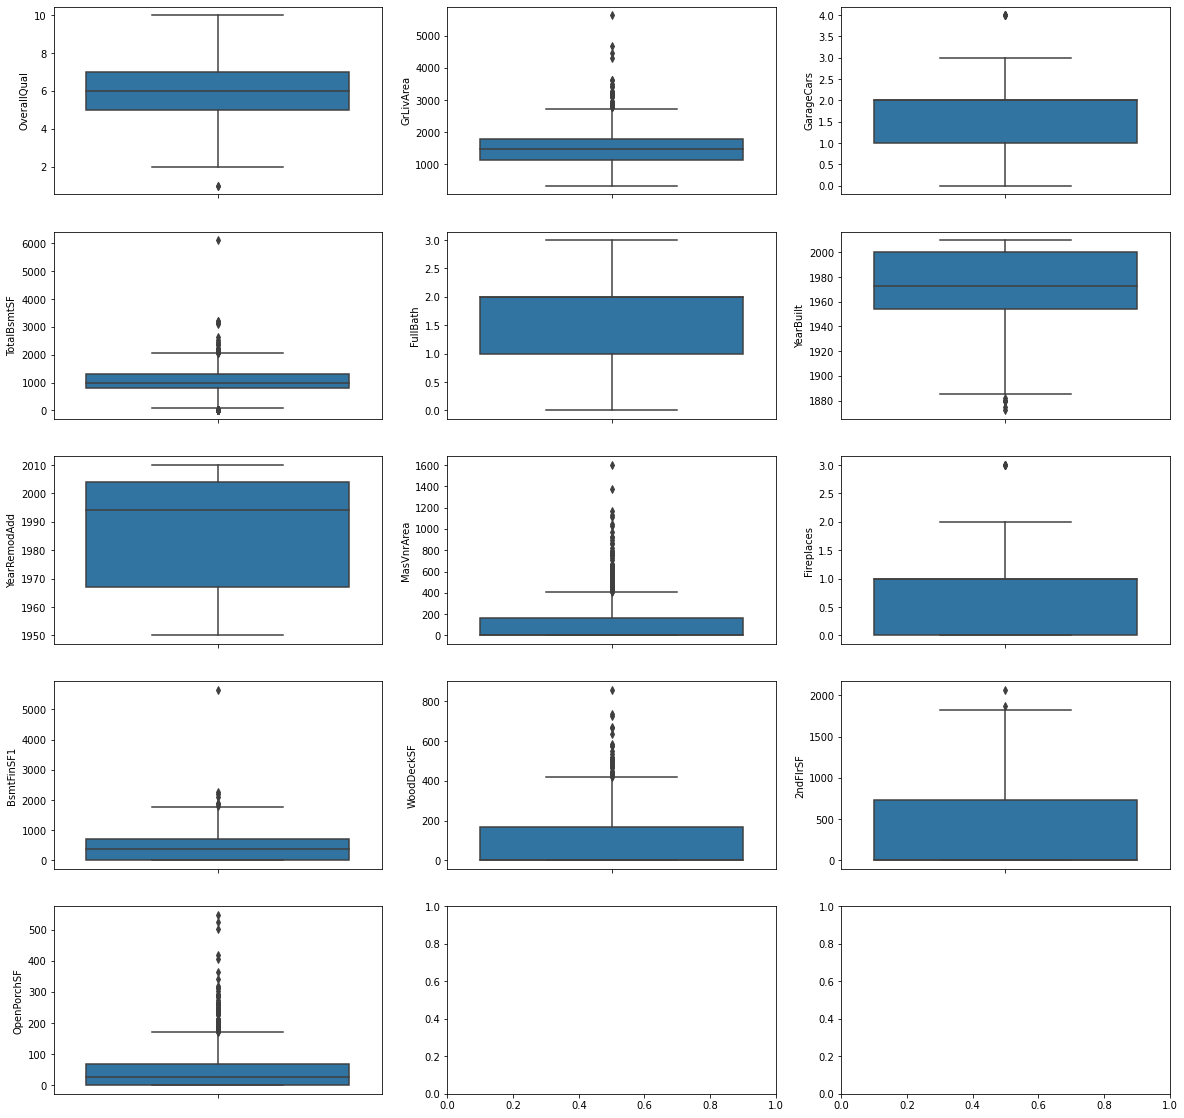

In [24]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
train_num_cols = train_data_num.columns.tolist()[:-1]

for i, ax in enumerate(fig.axes):
    if i < len(train_num_cols):
        sns.boxplot(data=train_data_num, y=train_num_cols[i], ax=ax)

To get out of outliers we will floor their values based on quantile. For outliers searching we will use Z-score from scipy library.

In [25]:
from scipy import stats

for col in train_num_cols:
    z_upper_train = stats.zscore(train_data_num[col]) > 3
    z_lower_train = stats.zscore(train_data_num[col]) < -3
    q1, q3 = train_data_num[col].quantile([0.25, 0.75])
    
    train_data_num[z_upper_train] = q3
    train_data_num[z_lower_train] = q1
    
    z_upper_test = stats.zscore(test_data_num[col]) > 3
    z_lower_test = stats.zscore(test_data_num[col]) < -3
    q1, q3 = test_data_num[col].quantile([0.25, 0.75])
    
    test_data_num[z_upper_test] = q3
    test_data_num[z_lower_test] = q1

# Categorical Data

feature extracting

In [26]:
categorical_features = [col for col in train_data.columns if train_data.dtypes[col] == 'object']

# training data
train_data_cat = train_data[categorical_features + ['SalePrice']]

# test data
test_data_cat = test_data[categorical_features]

train_data_cat.shape, test_data_cat.shape

((1460, 44), (1459, 43))

Now we are going look at countplots of each categorical feature to determine dominating categories for each feature in data.

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/445901859.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/445901859.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/445901859.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/445901859.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/445901859.py:5: UserWarning: FixedFormatter should o

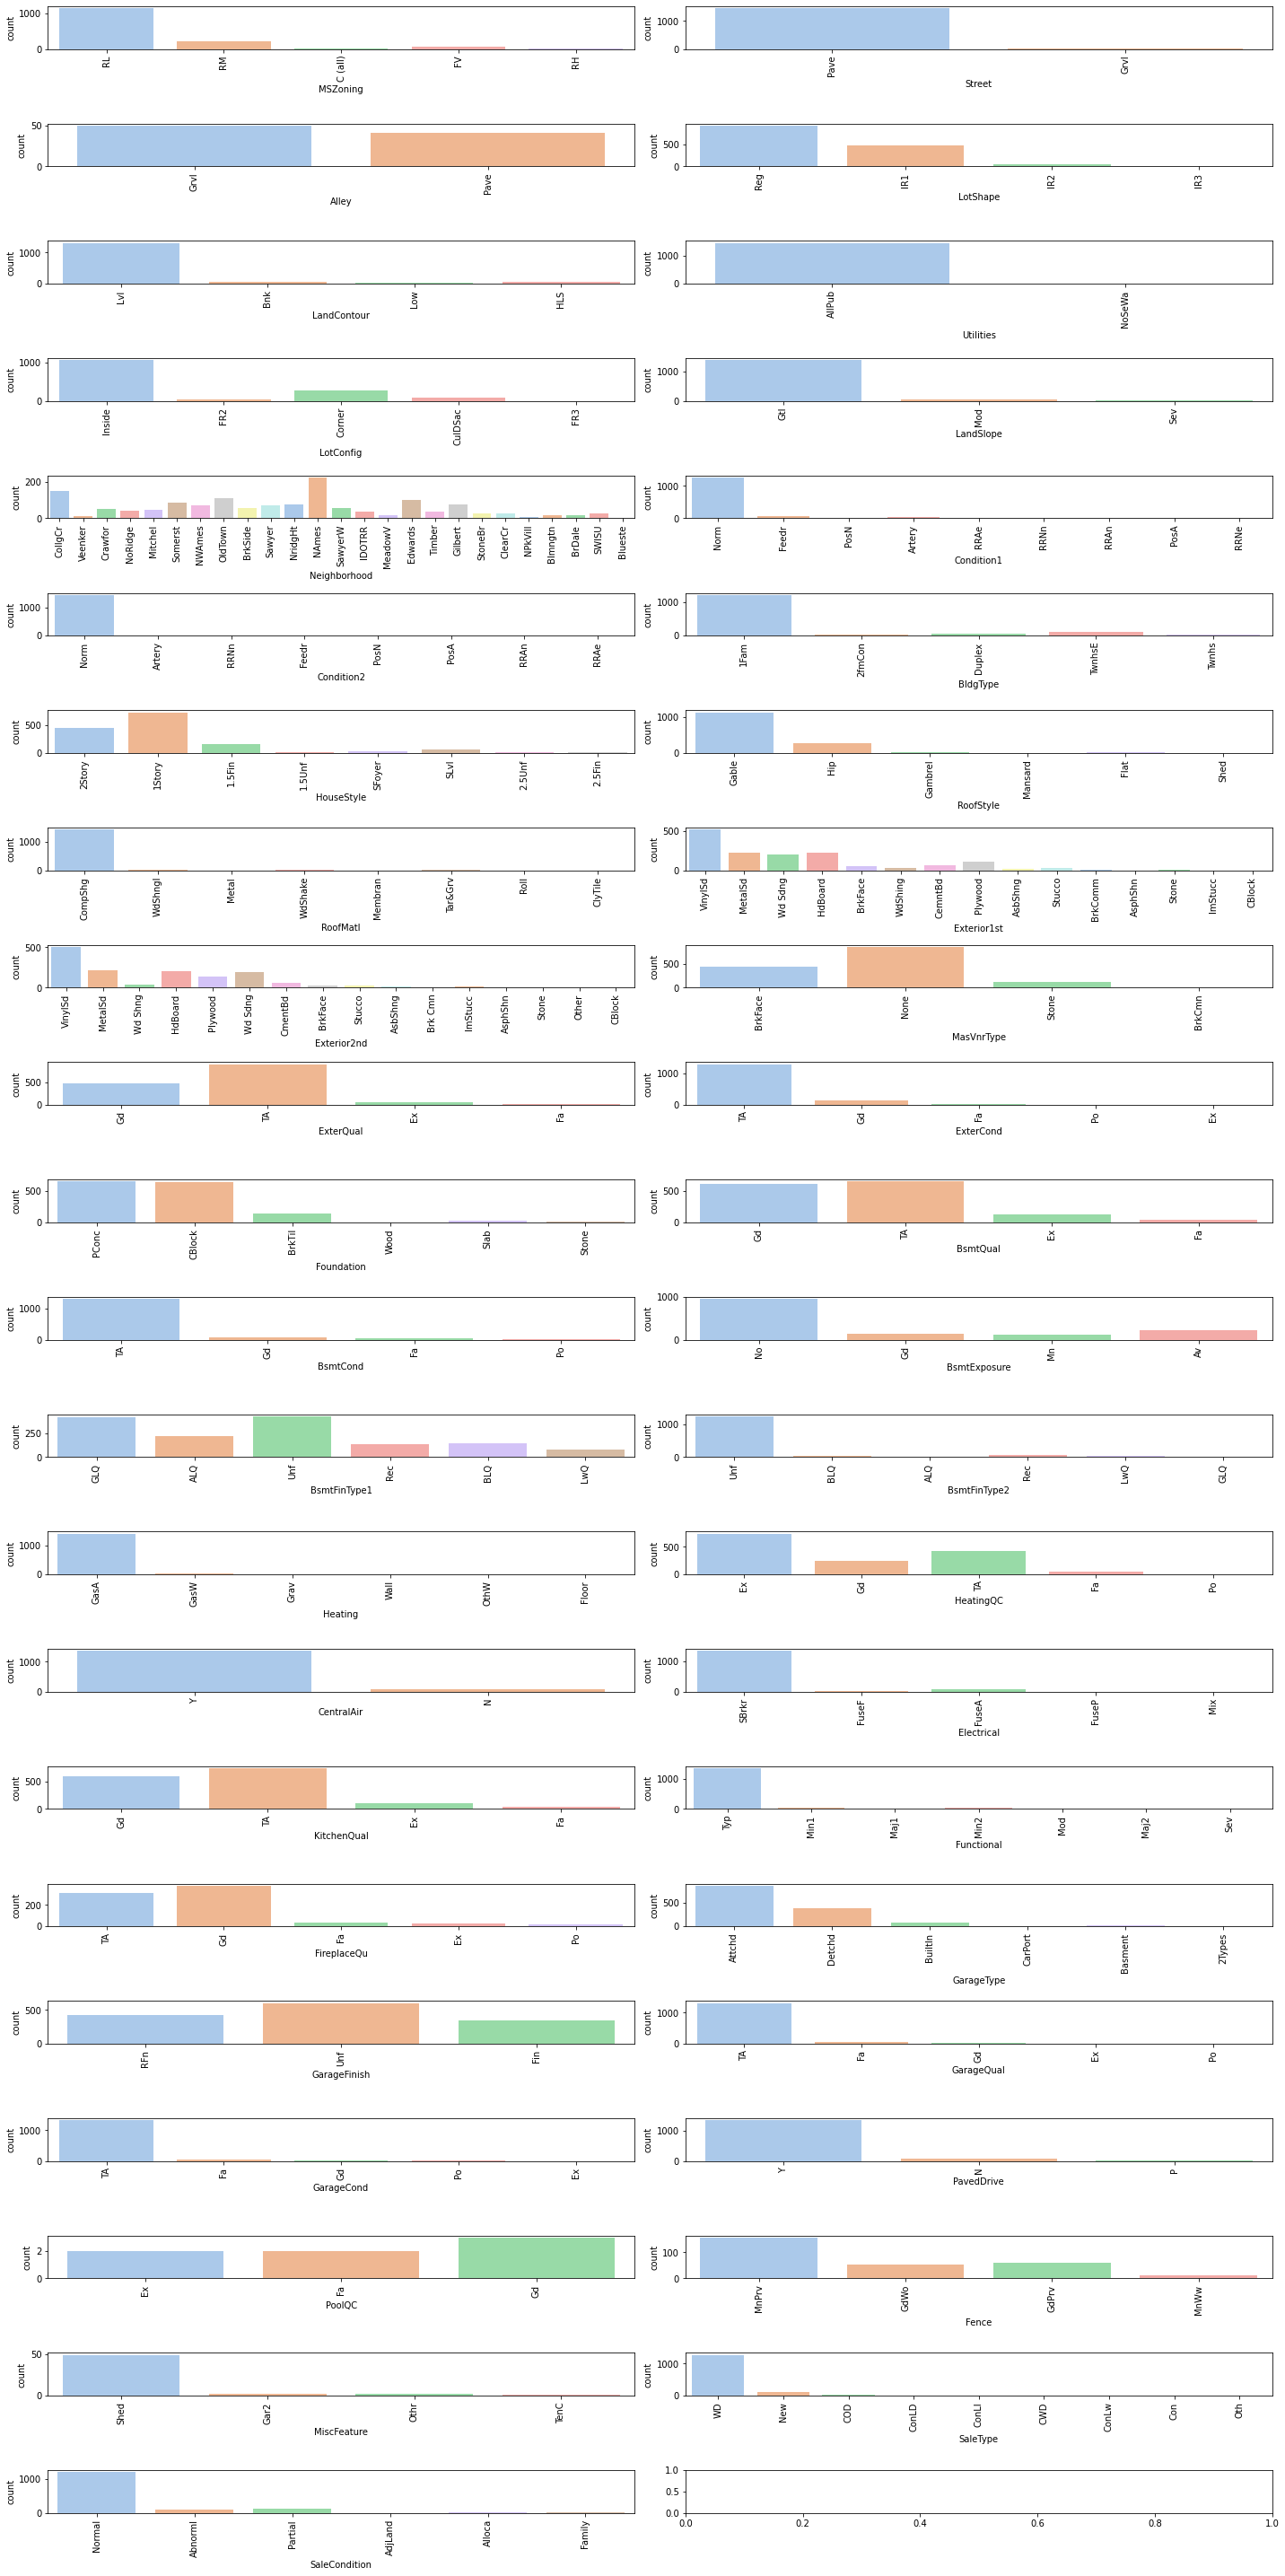

In [27]:
fig, ax = plt.subplots(round(len(train_data_cat.columns) / 2), 2, figsize=(20, 40))

for i, ax in enumerate(fig.axes):
    if i < len(train_data_cat.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(data=train_data_cat, x=train_data_cat.columns[i], ax=ax, palette='pastel')
        
fig.tight_layout()

In [28]:
features_to_drop = ['Street', 
                    'LandContour', 
                    'Utilities', 
                    'LandSlope', 
                    'Condition2', 
                    'RoofMatl', 
                    'BsmtCond', 
                    'BsmtFinType2', 
                    'Heating', 
                    'CentralAir', 
                    'Electrical',
                    'Functional',
                    'GarageQual',
                    'GarageCond',
                    'PavedDrive'
                   ]

train_data_cat.drop(features_to_drop, axis=1, inplace=True)
test_data_cat.drop(features_to_drop, axis=1, inplace=True)

train_data_cat.shape, test_data_cat.shape

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/1051728874.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cat.drop(features_to_drop, axis=1, inplace=True)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/1051728874.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cat.drop(features_to_drop, axis=1, inplace=True)


((1460, 29), (1459, 28))

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4124362514.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4124362514.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4124362514.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4124362514.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4124362514.py:5: UserWarning: FixedFormatter sho

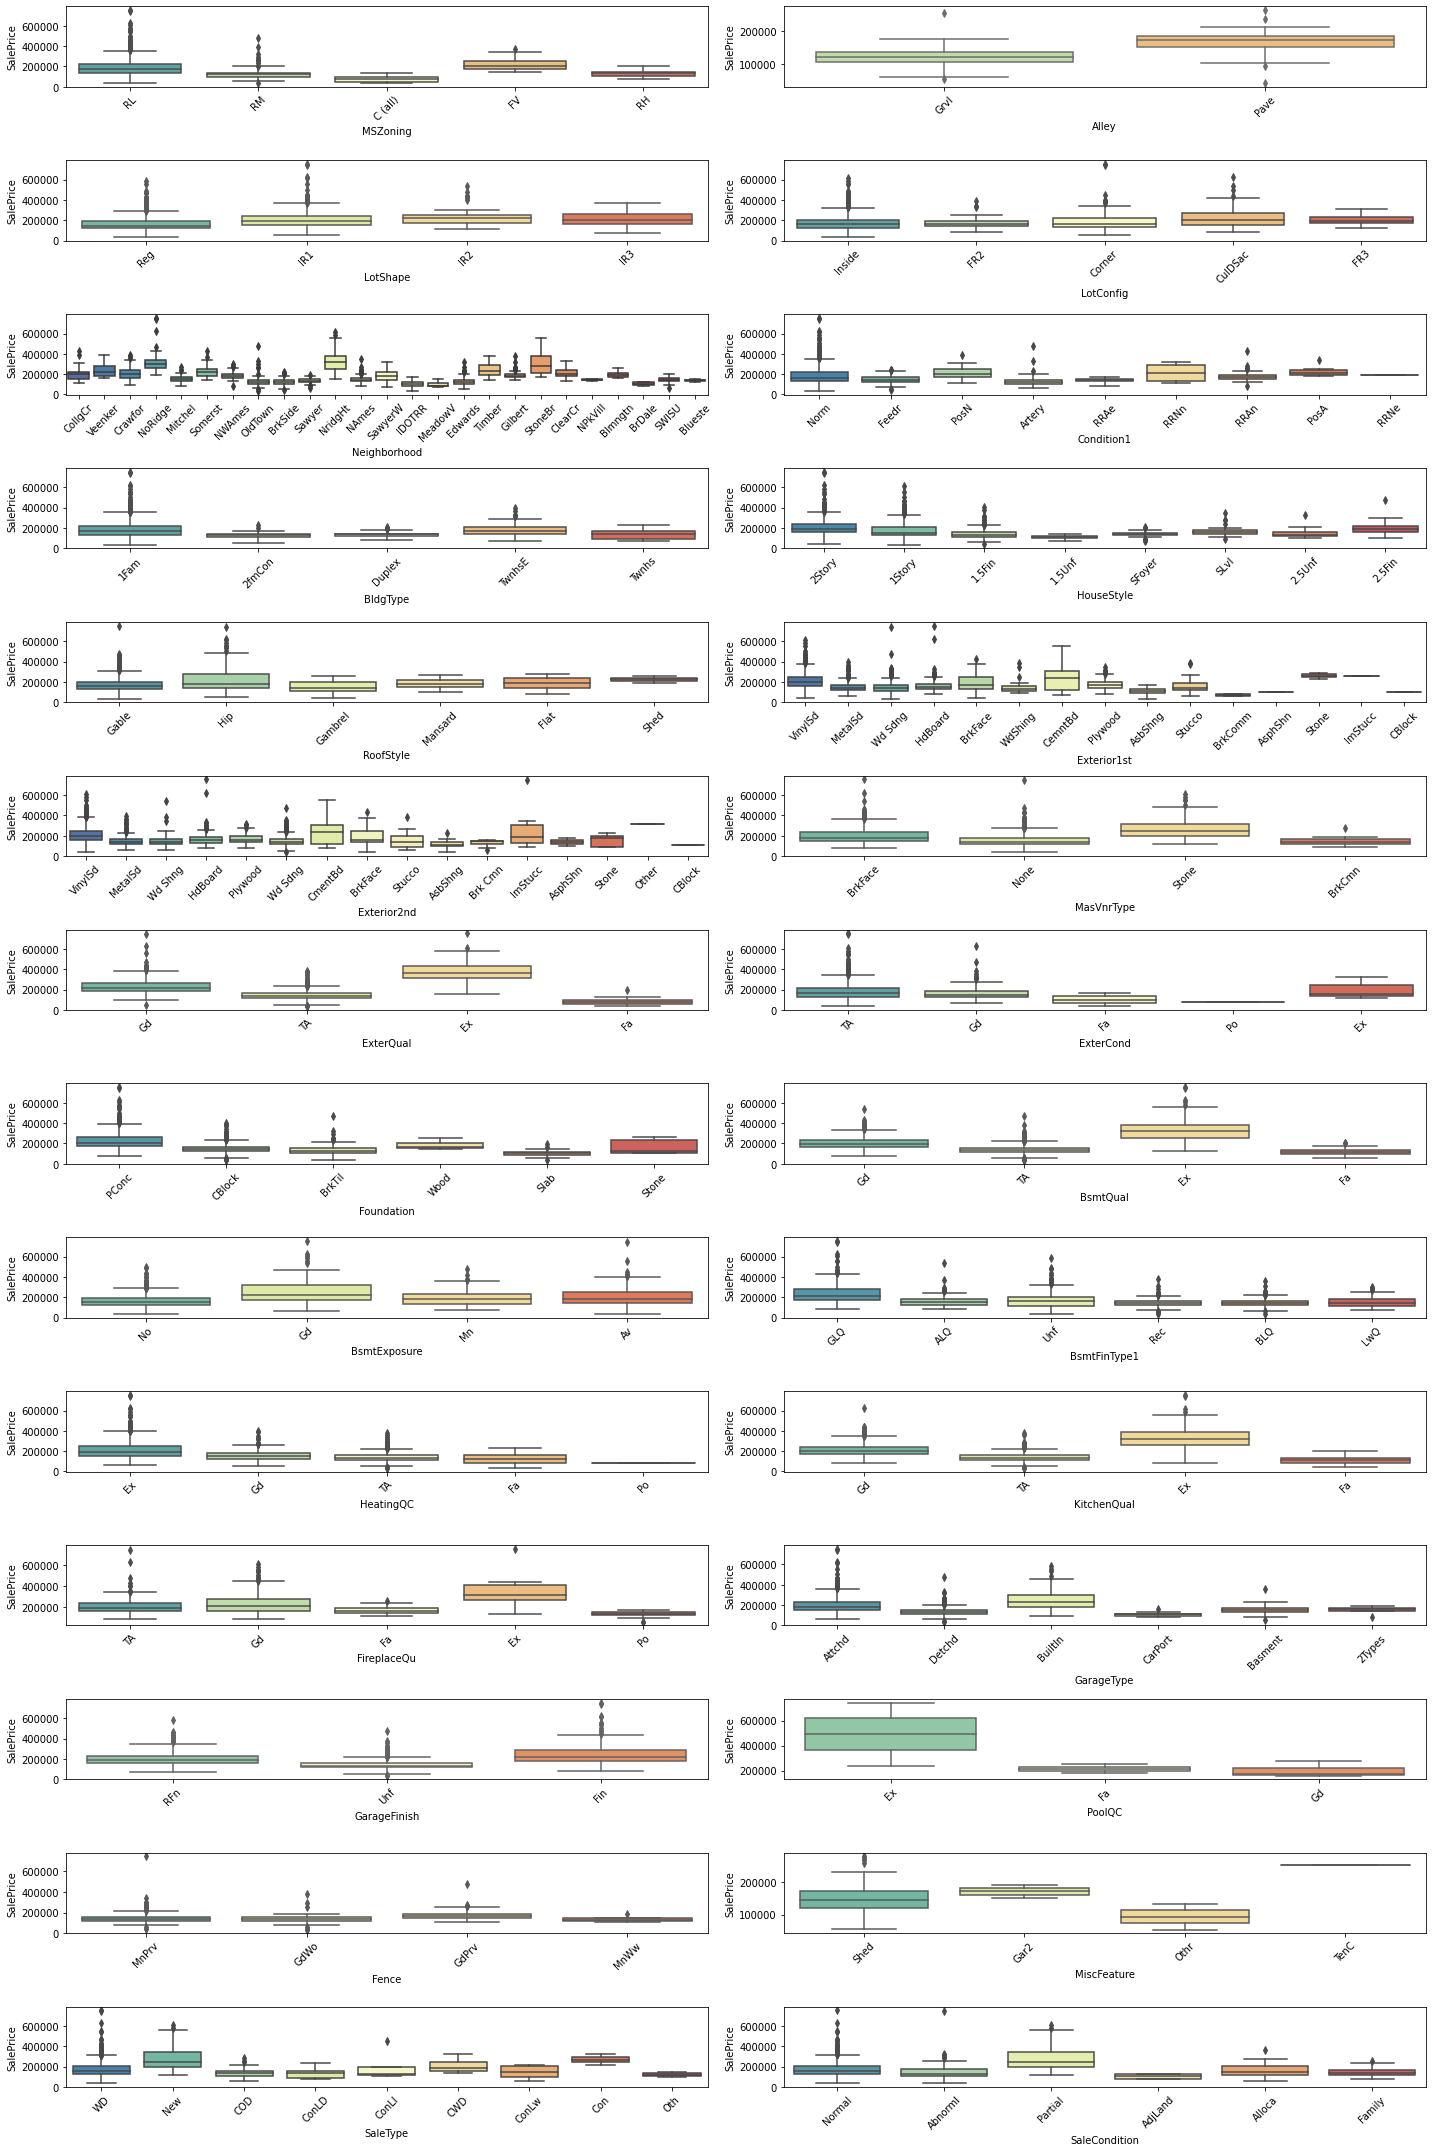

In [29]:
fig, ax = plt.subplots(round(len(train_data_cat.columns) / 2), 2, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    if i < len(train_data_cat.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(data=train_data_cat, x=train_data_cat.columns[i], y='SalePrice', ax=ax, palette='Spectral_r')
        
fig.tight_layout() 

It seems a few features have similar distributions of SalePrice:

* Exterior1st and Exterior2nd
* ExterQual and MasVnrType
* BsmtQual and BsmtExposure

Based on the similarity of their distributions, we can say that these features are highly correlated with each other. Therefore, we can drop one feature from each pair.

In [30]:
train_data_cat.drop(['Exterior2nd', 'MasVnrType', 'BsmtExposure'], axis=1, inplace=True)
test_data_cat.drop(['Exterior2nd', 'MasVnrType', 'BsmtExposure'], axis=1, inplace=True)

train_data_cat.shape, test_data_cat.shape

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4124082155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cat.drop(['Exterior2nd', 'MasVnrType', 'BsmtExposure'], axis=1, inplace=True)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4124082155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cat.drop(['Exterior2nd', 'MasVnrType', 'BsmtExposure'], axis=1, inplace=True)


((1460, 26), (1459, 25))

## Filling empty values

Firstly, let's take a look how many empty values each feature has.

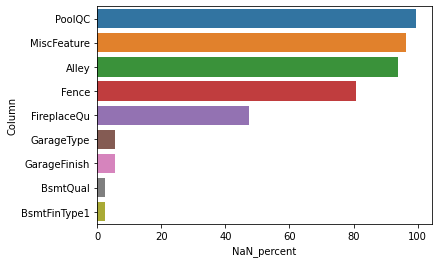

In [31]:
cols_null_train = train_data_cat.columns[train_data_cat.isnull().any()]
nan_counts_train = pd.DataFrame({
    'Column': cols_null_train,
    'NaN_percent': [train_data_cat[col].isnull().sum() * 100 / len(train_data_cat) for col in cols_null_train]
})

nan_counts_train.sort_values('NaN_percent', ascending=False, inplace=True, ignore_index=False)
sns.barplot(data=nan_counts_train, y='Column', x='NaN_percent');

In the training data we can see that five features have more than 45% missing values. Filling empty values by feature's mode will signinficantly modify distribution so we will drop them.

In [32]:
train_data_cat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
test_data_cat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/811121774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/811121774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)


We will also fill empty values by feature's mode in other features.

In [33]:
for col in ['GarageType', 'GarageFinish', 'BsmtQual', 'BsmtFinType1']:
    train_data_cat[col].fillna(train_data_cat[col].mode()[0], inplace=True)
    test_data_cat[col].fillna(train_data_cat[col].mode()[0], inplace=True)
    

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/291561238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cat[col].fillna(train_data_cat[col].mode()[0], inplace=True)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/291561238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cat[col].fillna(train_data_cat[col].mode()[0], inplace=True)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/291561238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [34]:
train_data_cat.isnull().sum()

MSZoning         0
LotShape         0
LotConfig        0
Neighborhood     0
Condition1       0
BldgType         0
HouseStyle       0
RoofStyle        0
Exterior1st      0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtFinType1     0
HeatingQC        0
KitchenQual      0
GarageType       0
GarageFinish     0
SaleType         0
SaleCondition    0
SalePrice        0
dtype: int64

In [35]:
test_data_cat.isnull().sum()

MSZoning         4
LotShape         0
LotConfig        0
Neighborhood     0
Condition1       0
BldgType         0
HouseStyle       0
RoofStyle        0
Exterior1st      1
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtFinType1     0
HeatingQC        0
KitchenQual      1
GarageType       0
GarageFinish     0
SaleType         1
SaleCondition    0
dtype: int64

It seems like we have a few empty values in test data. We will get rid of it with similar method.

In [36]:
cols_null_test = test_data_cat.columns[test_data_cat.isnull().any()]

for col in cols_null_test:
    test_data_cat[col].fillna(test_data_cat[col].mode()[0], inplace=True)
    
test_data_cat.isnull().sum()

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4058097217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cat[col].fillna(test_data_cat[col].mode()[0], inplace=True)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4058097217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cat[col].fillna(test_data_cat[col].mode()[0], inplace=True)
/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/4058097217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

MSZoning         0
LotShape         0
LotConfig        0
Neighborhood     0
Condition1       0
BldgType         0
HouseStyle       0
RoofStyle        0
Exterior1st      0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtFinType1     0
HeatingQC        0
KitchenQual      0
GarageType       0
GarageFinish     0
SaleType         0
SaleCondition    0
dtype: int64

In [37]:
train_data_cat.shape, test_data_cat.shape

((1460, 21), (1459, 20))

Finally, we have 20 categorical features in our data. However, before we go next we need to transform data from categories into binary.

## Transform Categories

In [38]:
train_data_cat.drop(['SalePrice'], axis=1, inplace=True)

train_cat_dummies = pd.get_dummies(train_data_cat)
train_cat_dummies

/var/folders/kx/1d500s1n1x324mhphv8tslsm0000gn/T/ipykernel_1285/944244446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cat.drop(['SalePrice'], axis=1, inplace=True)


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1456,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1457,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1458,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [39]:
test_cat_dummies = pd.get_dummies(test_data_cat)
test_cat_dummies.shape

(1459, 137)

Training data contains more columns than the test data. Training and test data need to have an equeal columns count. Let's find differences in data.

In [40]:
dif = [col for col in train_cat_dummies.columns if col not in test_cat_dummies.columns]
print('Found differences in: ', dif)

Found differences in:  ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone']


Now we can drop it.

In [41]:
train_cat_dummies.drop(dif, axis=1, inplace=True)

train_cat_dummies.shape, test_cat_dummies.shape

((1460, 137), (1459, 137))

We have prepared categorical features to our model. Of course, 137 features it's too much so in future we will select the most important for predictions features. Now we can merge numerical and categorical data.

In [42]:
train_data_new = pd.concat([train_data_num, train_cat_dummies], axis=1)
test_data_new = pd.concat([test_data_num, test_cat_dummies], axis=1)

train_data_new.shape, test_data_new.shape

((1460, 151), (1459, 150))

# Feature Engineering

Now we can create new features that can help us imporve our predictions.

In [43]:
# Age of house from the year of construction
train_data_new['Age'] = train_data_new['YearBuilt'].max() - train_data_new['YearBuilt']
test_data_new['Age'] = test_data_new['YearBuilt'].max() - test_data_new['YearBuilt']

In [44]:
# Age since renovating
train_data_new['Renovate'] = train_data_new['YearRemodAdd'] - test_data_new['YearBuilt']
test_data_new['Renovate'] = test_data_new['YearRemodAdd'] - test_data_new['YearBuilt']

train_data_new['Renovate'] = np.where(train_data_new['Renovate'] < 0, 0, train_data_new['Renovate'])
test_data_new['Renovate'] = np.where(test_data_new['Renovate'] < 0, 0, test_data_new['Renovate'])

# Drop YearBuilt
train_data_new.drop(['YearBuilt'], axis=1, inplace=True)
test_data_new.drop(['YearBuilt'], axis=1, inplace=True)

# Drop YearRemodAdd
train_data_new.drop(['YearRemodAdd'], axis=1, inplace=True)
test_data_new.drop(['YearRemodAdd'], axis=1, inplace=True)

In [45]:
# Artificial feature combines OverallQual and GrLivArea
train_data_new['Qual_Area'] = train_data_new['OverallQual'] * train_data_new['GrLivArea']
test_data_new['Qual_Area'] = test_data_new['OverallQual'] * test_data_new['GrLivArea']

Now we look at continuous features. We try to mitigate the strong variance of some variables by using log transformation. It make predictions easier for our model because of normalizing data.

In [46]:
cont_features = train_data_new.select_dtypes(include=['int', 'float']).drop(['SalePrice'], axis=1).columns.tolist()

cont_data = train_data_new.loc[:, cont_features]
cont_data.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,MasVnrArea,Fireplaces,BsmtFinSF1,WoodDeckSF,2ndFlrSF,OpenPorchSF,Age,Renovate,Qual_Area
0,7.0,1710.0,2.0,856.0,2.0,196.0,0.0,706.0,0.0,854.0,61.0,7.0,42.0,11970.0
1,6.0,1262.0,2.0,1262.0,2.0,0.0,1.0,978.0,298.0,0.0,0.0,34.0,18.0,7572.0
2,7.0,1786.0,2.0,920.0,2.0,162.0,1.0,486.0,0.0,866.0,42.0,9.0,5.0,12502.0
3,7.0,1717.0,3.0,756.0,1.0,0.0,1.0,216.0,0.0,756.0,35.0,95.0,0.0,12019.0
4,8.0,2198.0,3.0,1145.0,2.0,350.0,1.0,655.0,192.0,1053.0,84.0,10.0,8.0,17584.0


In [47]:
skew_data = pd.DataFrame({
    'Column': cont_features,
    'Skew': abs(cont_data.skew())
}).sort_values('Skew', ascending=False)

skew_data

,Column,Skew
OverallQual,OverallQual,6.678870
FullBath,FullBath,6.658914
GarageCars,GarageCars,6.656252
Fireplaces,Fireplaces,6.643810
Renovate,Renovate,4.645645
Age,Age,4.109832
MasVnrArea,MasVnrArea,2.095422
OpenPorchSF,OpenPorchSF,1.429083
Qual_Area,Qual_Area,1.185957
WoodDeckSF,WoodDeckSF,1.080558


In [48]:
skew_features = skew_data[skew_data['Skew'] > 0.5]['Column'].tolist()
skew_features

['OverallQual',
 'FullBath',
 'GarageCars',
 'Fireplaces',
 'Renovate',
 'Age',
 'MasVnrArea',
 'OpenPorchSF',
 'Qual_Area',
 'WoodDeckSF',
 '2ndFlrSF',
 'BsmtFinSF1']

In [49]:
# Adding 1 to avoid logarithm of 0
for col in skew_features:
    train_data_new[col] = np.log(train_data_new[col] + 1)
    test_data_new[col] = np.log(test_data_new[col] + 1)

Looking at distribution from the beginning, we can see that SalePrice feature is skewed too so we use log transformation for it.

In [50]:
train_data_new['SalePriceLog'] = np.log(train_data_new['SalePrice'])

train_data_new.drop('SalePrice', axis=1, inplace=True)

Let's take a look at numerical data distribution now.

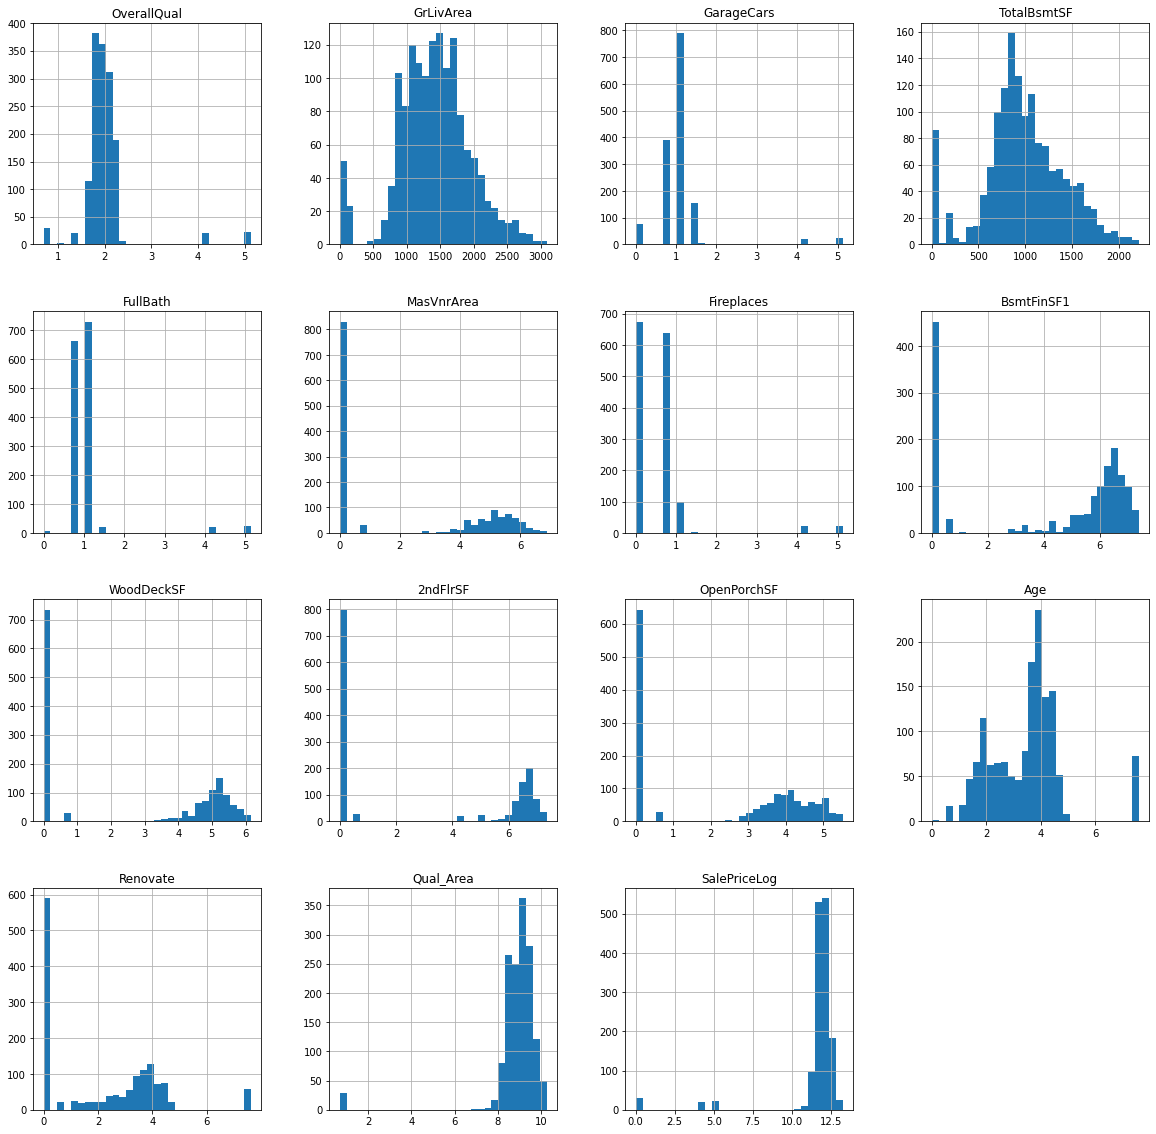

In [51]:
train_data_new_num = train_data_new.select_dtypes(include=['int', 'float'])
train_data_new_num.hist(figsize=(20, 20), bins=30);

# Modeling 

## Preparing Data

Before fitting and evaluating models we need to transform and split our data.

In [52]:
X = train_data_new.drop(['SalePriceLog'], axis=1)
y = train_data_new['SalePriceLog']

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (1460, 151)
y shape:  (1460,)


In [53]:
# Standardize data
scaler = StandardScaler().fit(X)

Now we should select the most important features from all of we having now. We will use backward feature elimination for it.

In [60]:
# import statsmodels.api as sm

# def backward_elimination(X, y, threshold=0.05):
#     features = X.columns.tolist()
    
#     while True:
#         changed = False
#         model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[features]))).fit()
#         pvalues = model.pvalues.iloc[1:]
#         print("***********************")
#         print(pvalues)
#         worst_pval = pvalues.max()
#         if worst_pval > threshold:
#             changed = True
#             worst_fet = pvalues.idxmax()
#             print("***********************")
#             print(worst_fet)
#             features.remove(worst_fet)
#         if not changed:
#             break
            
#     return features

In [83]:
import statsmodels.api as sm

def backward_elimination(X, y, threshold=0.05):
    features = X.columns.tolist()
    
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[features].fillna(0)))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold:
            changed = True
            worst_fet = pvalues.idxmax()
            features.remove(worst_fet)
        if not changed:
            break
            
    return features

In [84]:
selected_features = backward_elimination(X, y)

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'FullBath',
 'Fireplaces',
 'BsmtFinSF1',
 'WoodDeckSF',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'Neighborhood_BrkSide',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Condition1_Norm',
 'Condition1_RRAe',
 'BldgType_1Fam',
 'BldgType_2fmCon',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'RoofStyle_Flat',
 'Exterior1st_AsbShng',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_VinylSd',
 'ExterQual_Ex',
 'ExterQual_Fa',
 'ExterQual_Gd',
 'ExterQual_TA',
 'ExterCond_Ex',
 'ExterCond_Gd',
 'ExterCond_Po',
 'ExterCond_TA',
 'Foundation_CBlock',
 'Foundation_Stone',
 'BsmtQ

In [85]:
X = X.loc[:, selected_features]
test_data_new = test_data_new.loc[:, selected_features]

Now we can divide data into test and validation data.

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
print('Train size: ', X_train.shape, y_train.shape)
print('Validation size: ', X_val.shape, y_val.shape)

Train size:  (1241, 74) (1241,)
Validation size:  (219, 74) (219,)


# Predict and Solve

Now we are ready to use models for predicting houses prices. We will estimate queality of our predictions with 2 metrics: RMSE (main metric, checking in Kaggle submission) and R^2 score. Next we will use the following models:

* Linear Regression
* Ridge Regression (L2 penalty)
* Lasso Regression (L1 penalty)
* SVR
* Decision Tree
* Random Forest
* XGBoost
* Gradient Boosting
* CatBoost

In [87]:
# Creating RMSE

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Creating estimating function

r2_list = []
rmse_list = []

def get_metrics(model):
    r2 = model.score(X_val, y_val)
    rmse = rmse_score(y_val, model.predict(X_val))
    r2_list.append(r2)
    rmse_list.append(rmse)
    print('Cross validation score: ', cross_val_score(model, X_train, y_train, cv=5))
    print('R2 score: ', r2)
    print('RMSE: ', rmse)

## Linear Regression

In [89]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

get_metrics(linreg)

Cross validation score:  [0.9932582  0.99411685 0.99538914 0.9922567  0.9894313 ]
R2 score:  0.9941457223749902
RMSE:  0.16669758438295484


## Ridge Regression

In [90]:
ridge_reg = Ridge(alpha=.001)
ridge_reg.fit(X_train, y_train)

get_metrics(ridge_reg)

Cross validation score:  [0.99325861 0.99411731 0.99538888 0.99225655 0.98943149]
R2 score:  0.9941461517593883
RMSE:  0.1666914710194433


## Lasso Regression

In [91]:
lasso_reg = Lasso(alpha=.001)
lasso_reg.fit(X_train, y_train)

get_metrics(lasso_reg)

Cross validation score:  [0.99330196 0.99350441 0.99517671 0.99178901 0.98828264]
R2 score:  0.9940917920896433
RMSE:  0.1674636429254929


## SVR

In [92]:
svr = SVR()
svr.fit(X_train, y_train)

get_metrics(svr)

Cross validation score:  [0.92826901 0.90542398 0.90426176 0.90793717 0.94291775]
R2 score:  0.9242087707293267
RMSE:  0.5997940110881671


# Decision Tree

Before using decision tree model we should select the most effective depth. Let's see how rmse depends from tree's depth.

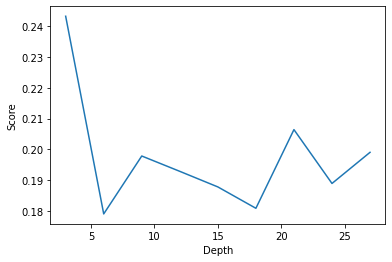

In [93]:
depths = []
scores = []

for d in range(3, 30, 3):
    m = DecisionTreeRegressor(max_depth=d).fit(X_train, y_train)
    depths.append(d)
    scores.append(rmse_score(y_val, m.predict(X_val)))

dt_scores = pd.DataFrame({
    'Depth': depths,
    'Score': scores
})
sns.lineplot(data=dt_scores, x='Depth', y='Score');

In [94]:
tree_depth = int(dt_scores.loc[dt_scores['Score'] == dt_scores['Score'].min(), 'Depth'])
tree_depth

6

In [95]:
dt = DecisionTreeRegressor(max_depth=tree_depth)
dt.fit(X_train, y_train)

get_metrics(dt)

Cross validation score:  [0.99153904 0.99303168 0.99602199 0.99159079 0.98876121]
R2 score:  0.9932516878684103
RMSE:  0.17897411785073086


# Random Forest

Now we will see how rmse depends from n_estimators

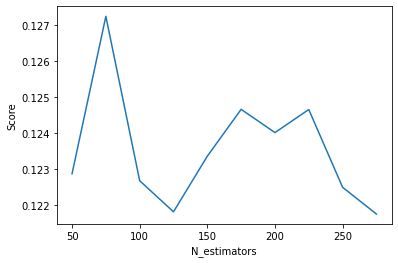

In [96]:
n_est = []
rf_rmse = []

for n in range(50, 300, 25):
    m = RandomForestRegressor(n_estimators=n).fit(X_train, y_train)
    n_est.append(n)
    rf_rmse.append(rmse_score(y_val, m.predict(X_val)))

rf_scores = pd.DataFrame({
    'N_estimators': n_est,
    'Score': rf_rmse
})
sns.lineplot(data=rf_scores, x='N_estimators', y='Score');

In [97]:
n_estimators = int(rf_scores.loc[rf_scores['Score'] == rf_scores['Score'].min(), 'N_estimators'])
n_estimators

275

In [98]:
rf = RandomForestRegressor(n_estimators=n_estimators)
rf.fit(X_train, y_train)

get_metrics(rf)

Cross validation score:  [0.9947439  0.99540585 0.99781372 0.99496135 0.99351399]
R2 score:  0.9967985232520954
RMSE:  0.12327296034357055


In [99]:
rf = RandomForestRegressor(n_estimators=n_estimators)
rf.fit(X_train, y_train)

get_metrics(rf)

Cross validation score:  [0.99472285 0.99529372 0.99780063 0.99502473 0.99342249]
R2 score:  0.9968881364202646
RMSE:  0.12153543630764138


## XGBoost

In [100]:
xgb = XGBRegressor(n_estimators=n_estimators)
xgb.fit(X_train, y_train)

get_metrics(xgb)

Cross validation score:  [0.99473986 0.99404675 0.99776512 0.99485849 0.99424869]
R2 score:  0.9965227982027236
RMSE:  0.12847173735786754


## Gradient Boosting

In [101]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

get_metrics(gbr)

Cross validation score:  [0.99542974 0.99542178 0.99790235 0.99558005 0.99436558]
R2 score:  0.9968326595069978
RMSE:  0.12261399027179443


## CatBoost

In [102]:
cbr = CatBoostRegressor()
cbr.fit(X_train, y_train, verbose=0)

cbr_pred = cbr.predict(X_val)

cbr_r2 = r2_score(y_val, cbr_pred)
cbr_rmse = rmse_score(y_val, cbr_pred)
r2_list.append(cbr_r2)
rmse_list.append(cbr_rmse)

print('R2 score:', cbr_r2)
print('RMSE score:', cbr_rmse)

R2 score: 0.9943011349508821
RMSE score: 0.16447005435974313


In [103]:
model_list = ['linreg', 'ridge', 'lasso', 'svr', 'dt', 'rf', 'xgb', 'gbr', 'cbr']

summary = pd.DataFrame({
    'Model': model_list,
    'R2': r2_list,
    'RMSE': rmse_list
})
summary.sort_values('RMSE')

ValueError: All arrays must be of the same length

In [104]:
y_pred = np.exp(cbr.predict(test_data_new))


submission = pd.DataFrame({
    'Id': id_test,
    'SalePrice': y_pred
})

submission.head()

,Id,SalePrice
0,1461,113740.154835
1,1462,166469.290279
2,1463,181698.810871
3,1464,197281.831920
4,1465,187680.836304


In [105]:
# X_test = pd.read_csv('HPAR/test.csv')
# prediction = pd.DataFrame(X_test['Id'], columns=['Id'], )
# pre = pd.DataFrame(predictions, columns=['SalePrice'])
# prediction = pd.concat([prediction, pre], axis=1)
submission.to_csv('prediction.csv', index=False)